In [1]:
import sympy as sym
import sympy.physics.mechanics as me

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams
import FwtModels as fm
me.mechanics_printing()

In [3]:
# create instance of a simplified model parameters
p = dof2.Simplified2DofModel(inner_freq=2,inner_mass=4,mass_ratio=4)
p.g.value = 9.81
p.y_fwt = sym.Symbol('y_fwt')
p.alpha_fwt = fm.FwtVariable(0,'alpha_fwt')
p.alphadot_fwt = fm.FwtVariable(0,'alphadot_fwt')
p.Mthetadot_fwt = fm.FwtVariable(1.2,'Mthetadot_fwt')
p.e = p.c/2

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)

mw = fm.RigidElement.PointMass(wing_frame,p.m_w)
M_fwt = fm.MassMatrix(p.m,I_xx = p.I_xx)
m = fm.RigidElement(fwt_com_frame,M_fwt)

# External Forces
p.a_t = sym.pi * 2 - (sym.pi * 2/p.s)*p.y_fwt
AeroForces = ams.AeroModelv3(p,fwt_frame.Translate(0,p.y_fwt,0),p.a_t,(p.y_fwt,0,p.s),p.alpha_fwt,0,p.alphadot_fwt,p.Mthetadot_fwt,0)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce(p,[GravityForces,AeroForces])

# create instance of the model
sm = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)


In [20]:
p.m_w.value

Text(0.5, 0, 't [s]')

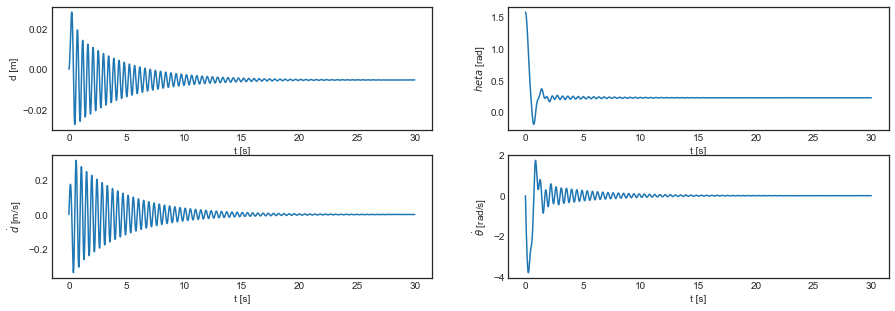

In [6]:
tmax, dt = 30, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 20

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
def fwt_1(t,x):
    foldAngle = x[0]
    stheta = np.sin(foldAngle)
    ctheta = np.cos(foldAngle)
    sLambda = np.sin(p.Lambda.value)
    alpha_r = arfunc(t,x)
    
    n = alpha_r*ctheta+sLambda*stheta
    d = alpha_r*sLambda*stheta-sLambda**2*ctheta+sLambda**2-1
    return np.arctan(-n/d)
    
def fwt_alpha(t,x):
    foldAngle = x[0]
    return np.arctan(np.sin(p.Lambda.value)*np.sin(foldAngle)) + np.cos(foldAngle)*arfunc(t,x)

def FwtAoA(t,x):
    Lambda = p.Lambda.value
    foldAngle = x[0]
    root_aoa = arfunc(t,x)   
    # get velocity vector in FWT frame
    v_x = (np.sin(Lambda)**2*np.cos(root_aoa)*np.cos(foldAngle) - np.sin(Lambda)**2*np.cos(root_aoa) - np.sin(Lambda)*np.sin(root_aoa)*np.sin(foldAngle) + np.cos(root_aoa))
    v_z = (np.sin(Lambda)*np.sin(foldAngle)*np.cos(root_aoa) + np.sin(root_aoa)*np.cos(foldAngle))
    return np.arctan(v_z/v_x)

p.V.value = Vfunc
p.alpha_r.value = arfunc
p.alpha_fwt.value = FwtAoA

y0 = [np.pi/2,0,0,0]
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

yData = solve_ivp(lambda t,y:sm.deriv(t,y,p.GetNumericTuple(y,t)),(0,tmax),y0,max_step=dt,t_eval=ts)

# interpolate data onto a uniform time grid

yi = yData.y
t = yData.t

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(2,2,figsize=(15,5))

# d plot
axes[0][0].plot(t,yi[2])
axes[0][0].set_ylabel('d [m]')
axes[0][0].set_xlabel('t [s]')

# theta plot
axes[0][1].plot(t,yi[0])
axes[0][1].set_ylabel('$\theta$ [rad]')
axes[0][1].set_xlabel('t [s]')


# ddot plot
axes[1][0].plot(t,yi[3])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[1])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

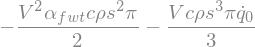

In [13]:
fwt_frame = symt.HomogenousTransform().R_x(p.q[0])
AeroForces = ams.AeroModelv3(p,fwt_frame.Translate(0,p.y_fwt,0),sym.pi*2,(p.y_fwt,0,p.s),p.alpha_fwt,0,p.alphadot_fwt,p.Mthetadot_fwt,0)


AeroForces.Q().subs({p.q[1]:0,p.qd[1]:0})[0].expand()

In [ ]:
plt.style.use('seaborn-whitegrid')
#plt.style.use(r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\Styles\presentation.mplstyle')
   
fig, axes = plt.subplots(3,1,figsize=(15,12))
#fig.tight_layout()
# d plot
axes[0].plot(t,yi[2])
axes[0].set_ylabel('d [m]')
axes[0].set_xlabel('t [s]')

# theta plot
axes[1].plot(t,yi[0])
axes[1].set_ylabel(r'$\theta$ [rad]')
axes[1].set_xlabel('t [s]')

# Local Angle of Attack plots
alphas = AeroForces.GetAlpha(p,yi[:4,:],1,t)
alphas2 = AeroForces.GetAlpha(p,yi[:4,:],0.5,t)



l1, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi[:4,:],1,t)))
l2, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi[:4,:],0.5,t)))
l3, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi[:4,:],0,t)))

#zero velocities
yi_v0 = yi[:4,:].copy()
yi_v0[[1,3],:] = 0
l4, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,yi_v0,0,t)))

l1.set_label('Tip')
l2.set_label('Mid-span')
l3.set_label('Root')
l4.set_label('Geometric')
axes[2].legend()
axes[2].set_ylabel(r'$\alpha_h(y_t)$')
axes[2].set_xlabel('t [s]')
#axes[3][0].set_ylim(0.5,1.5)
PhotoDir = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\Videos & Photos'+'\\'
plt.savefig(PhotoDir + r'ModelStates.png',transparent=True,bbox_inches='tight')

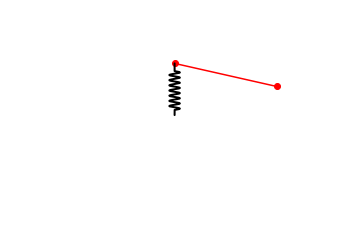

In [5]:
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Programs\ffmpeg-20200211-f15007a\bin\ffmpeg.exe'
#plt.rcParams['animation.ffmpeg_path'] = r'/Users/fintan/Documents/GitHub/ffmpeg'

spring_size = 0.5
fig = plt.figure()
ax = plt.axes(xlim=(-1.2,1.2),ylim=(-1.2,1.2))
ax.axis('equal')
ax.set()
fwt, = ax.plot([],[],'ro-')
spring = cpo.Spring.FromLengthAndAngle(np.pi/2,p.s.value,ax = ax)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    spring.ReplotSpring((0,0),np.pi,1+y0[2])
    fwt.set_data([0,p.s.value],[1,1])
    return spring.springObj,fwt
                    
def animate(i):
    theta = yi[0,i]
    d = yi[2,i]
    spring.ReplotSpring((0,0),np.pi,d+spring_size)
    fwt.set_data([0,p.s.value*np.cos(theta)],[d+spring_size,-p.s.value*np.sin(theta)+d+spring_size])
    return spring.springObj,

plt.axis('off')    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=20, blit=True)
#anim.save(f'basic_animation_{test_case+1}.mp4', fps=30)
HTML(anim.to_html5_video())